Welcome to the PROT_CLUST tool

🧬 PROT_CLUST: Protein-Protein Interaction Clustering Pipeline
This notebook manages the full workflow for the PROT_CLUST project. It handles environment setup, data import, preprocessing, clustering (Louvain & MCL), and result analysis.

1. Project Environment Setup

This section ensures all necessary directories (_raw, data, output, etc.) exist and that dependencies are met.

In [ ]:
import os
import sys
import subprocess
import platform
from pathlib import Path

# --- Configuration for Directory Structure ---
PROJECT_STRUCTURE = [
    "_raw",
    "data",
    "data/output",
    "features",
    "features/plotting",
    ".venv"
]

def create_structure():
    """Creates the necessary folder structure if it doesn't exist."""
    print(f"📁 Checking directory structure...")
    root_dir = Path.cwd() # Current working directory (assuming notebook is in root)
    
    for folder in PROJECT_STRUCTURE:
        folder_path = root_dir / folder
        if not folder_path.exists():
            print(f"   + Creating missing directory: {folder}/")
            os.makedirs(folder_path, exist_ok=True)
        else:
            pass # Directory exists, stay silent to keep output clean

def check_data_files():
    """Checks if raw data files (ignored by git) are present."""
    # Adjust filenames here if they change
    required_files = [
        Path("_raw/9606.protein.info.v12.0.txt"),
        Path("_raw/9606.protein.links.v12.0.min400.txt")
    ]
    
    missing_data = [f for f in required_files if not f.exists()]
    
    if missing_data:
        print("\n⚠️  MISSING DATA WARNING:")
        for f in missing_data:
            print(f"   - {f}")
        print("   -> Please download these from STRING DB or run your raw_data.py script.")
    else:
        print("✅ Raw data files detected.")

# Run the setup logic
print("--- ⚙️ Running Project Setup ---")
create_structure()
check_data_files()
print("--- Setup Complete ---\n")

2. Pipeline Orchestrator

We define a helper function to execute standalone scripts.

In [1]:
import os
import sys
import subprocess
import platform
from pathlib import Path

def run_script(script_path):
    """
    Executes a Python script using a subprocess to ensure clean execution context.
    """
    script_path = Path(script_path)
    
    if not script_path.exists():
        print(f"❌ FATAL ERROR: Could not find script at '{script_path}'")
        return

    print(f"\n--- 🚀 Starting {script_path.name}...")
    
    # Use the current Python executable (sys.executable) to run the script
    command = [sys.executable, str(script_path)]
    
    try:
        # Execute the script, streamlining output to this notebook
        process = subprocess.run(
            command, 
            check=True,
            stdout=sys.stdout,
            stderr=sys.stderr
        )
        print(f"--- ✅ {script_path.name} finished successfully.")
        
    except subprocess.CalledProcessError as e:
        print(f"\n--- ❌ ERROR: {script_path.name} failed with return code {e.returncode}.")

3. Pre-requisites

Checking system pre-requisites before starting heavy processing.

In [ ]:
# Run the prerequisite check
# run_script("pre_req.py")

4. Data Import

Importing data into the _raw folder

In [ ]:
# Define path to data import
data_import_script = Path("features") / "data_import.py"

# Run import
run_script(data_import_script)

5. Data Preprocessing

Cleaning the dataset and preparing the graph structures.

In [ ]:
# Run preprocessing
#run_script("features/preprocessing.py")

6. Clustering Algorithms
Run the graph clustering algorithms. You can uncomment the specific algorithms you wish to run for this session.

A. Louvain Clustering
Community detection based on modularity optimization.

B. Markov Clustering

In [3]:
# Uncomment to run Louvain Clustering
run_script("features/01_run_louvain.py")


--- 🚀 Starting 01_run_louvain.py...


KeyboardInterrupt: 

Overview of clustering Louvain

In [2]:
import sys
import pandas as pd
# Ensure python finds your modules
sys.path.append('features/prot_clust_modules')

# Import the new module
from cluster_overview import (
    get_clustering_summary, 
    generate_cluster_stats_table, 
    get_proteins_in_cluster
)

# Config
PICKLE_FILE = "data/output/louvain_clust_julle.pkl"
OUTPUT_DIR = "data/output"

In [3]:
# Get high-level facts about the network
df_summary = get_clustering_summary(PICKLE_FILE)


[OVERVIEW] Generating global network summary...

--- Network Summary ---


Total Clusters,Avg Cluster Size,Median Cluster Size,Largest Cluster,Smallest Cluster,Modularity Score
32,411.340000,376.500000,1140,10,0.757600


In [4]:
# Generate table for all clusters
df_all_clusters = generate_cluster_stats_table(
    PICKLE_FILE, 
    output_filename="all_cluster_metrics.csv", 
    output_dir=OUTPUT_DIR
)


[OVERVIEW] Calculating statistics for all clusters...
   ✅ Stats saved to: data/output/all_cluster_metrics.csv

--- Top 20 Largest Clusters ---


,Cluster ID,Size (Nodes),Edges,Density,Avg Clustering
0,4,1140,10282,0.0158,0.4271
1,9,901,5617,0.0139,0.3970
2,21,688,4411,0.0187,0.4624
3,13,678,9266,0.0404,0.5548
4,20,654,4997,0.0234,0.4143
5,22,652,6936,0.0327,0.4954
6,1,609,3502,0.0189,0.4532
7,29,596,3868,0.0218,0.5252
8,24,558,5873,0.0378,0.4708
9,27,539,3701,0.0255,0.4738


In [5]:
# Select a cluster ID you are interested in (e.g., based on the table above)
INTERESTING_CLUSTER_ID = 23

# Extract list
protein_list = get_proteins_in_cluster(
    PICKLE_FILE, 
    cluster_id=INTERESTING_CLUSTER_ID, 
    output_filename=f"proteins_in_cluster_{INTERESTING_CLUSTER_ID}.txt",
    output_dir=OUTPUT_DIR
)


[OVERVIEW] Fetching proteins for Cluster ID 23...
   ✅ Saved list to: data/output/proteins_in_cluster_23.txt

--- Proteins in Cluster 23 (Showing top 50 of 354) ---
ABHD16A, ADRM1, AGTRAP, AHSA1, AKIRIN2, ALX3, AMFR, ANKRD45, ANKZF1, ARHGEF15, ART3, ASPSCR1, ATXN3, AUP1, BAG1, BAG2, BAG3, BAG5, BAG6, BTBD9, C15orf40, CAAP1, CALR3, CALU, CAMLG, CCDC74B, CCDC92, CCT6B, CCT8L2, CDC37, CDC37L1, CDC42BPB, CDC42EP2, CDC42EP3, CDC42EP4, CDC42EP5, CHORDC1, CLPB, CRELD2, DDI1, DERL1, DERL2, DERL3, DESI1, DGCR2, DGCR6, DGCR6L, DNAH10, DNAJA1, DNAJA2
... and 304 more.


Running reproducibillity script - only run if of interest


--- 🚀 Starting 03_reproducibility.py...
--- ✅ 03_reproducibility.py finished successfully.
reproducibility_plot.png


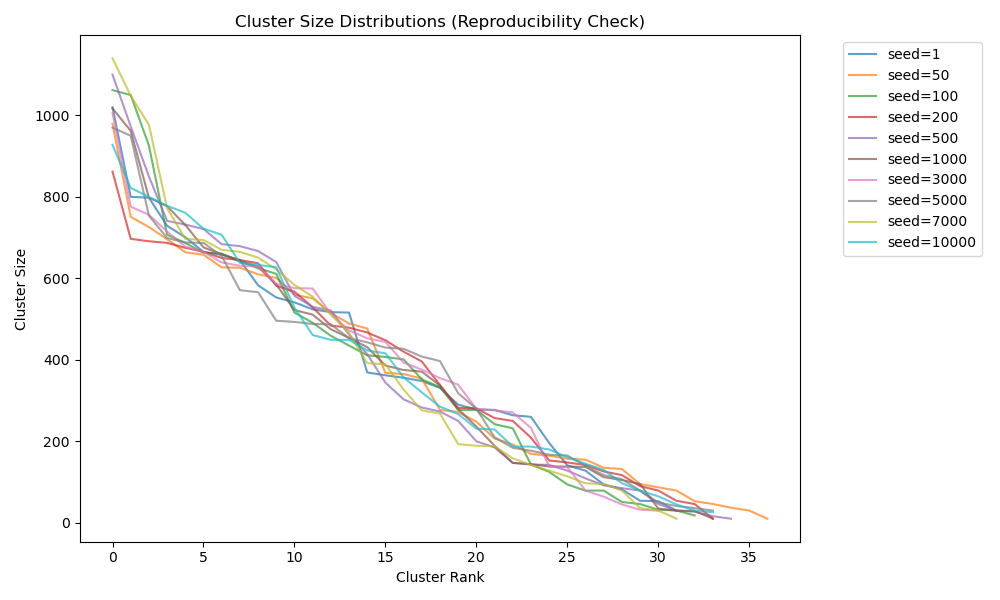

In [ ]:

# Uncomment to run analyze clusterers
run_script("features/03_reproducibility.py")

# View results
from IPython.display import Image, display
import os

# Define the path where the script saved the image
image_path = "data/output/images/reproducibility_plot.png"

# Check if file exists to avoid errors
if os.path.exists(image_path):
    print("reproducibility_plot.png")
    display(Image(filename=image_path))
else:
    print(f"❌ Image not found at {image_path}. Did the script run successfully?")



Running Target bottlenecks


--- 🔍 Analyzing Target: AGTRAP ---
[INFO] Found in Cluster #23 (Size: 354 nodes)
[INFO] Calculating network metrics (Degree, Betweenness, Clustering)...
   > Metrics computed in 2.78s
[INFO] Generating static PNG...
[INFO] Generating interactive HTML...
[SUCCESS] Analysis finished for AGTRAP.

✅ Results for Cluster 23:


,Protein,Total_Score,BC,Degree,Clustering
0,UFD1,67,0.170020,40,0.189463
1,DNAJB11,91,0.094386,31,0.208271
2,ZUP1,104,0.049165,24,0.103424
3,HSPA1L,117,0.044282,30,0.240021
4,AMFR,117,0.056762,33,0.277819
5,HSPA1A,121,0.032648,33,0.247955
6,STIP1,122,0.032602,36,0.263949
7,PDIA3,129,0.051193,19,0.220921
8,UBXN7,133,0.043740,28,0.255779
9,DNAJB1,139,0.015661,40,0.228813



--- Static Visualization ---


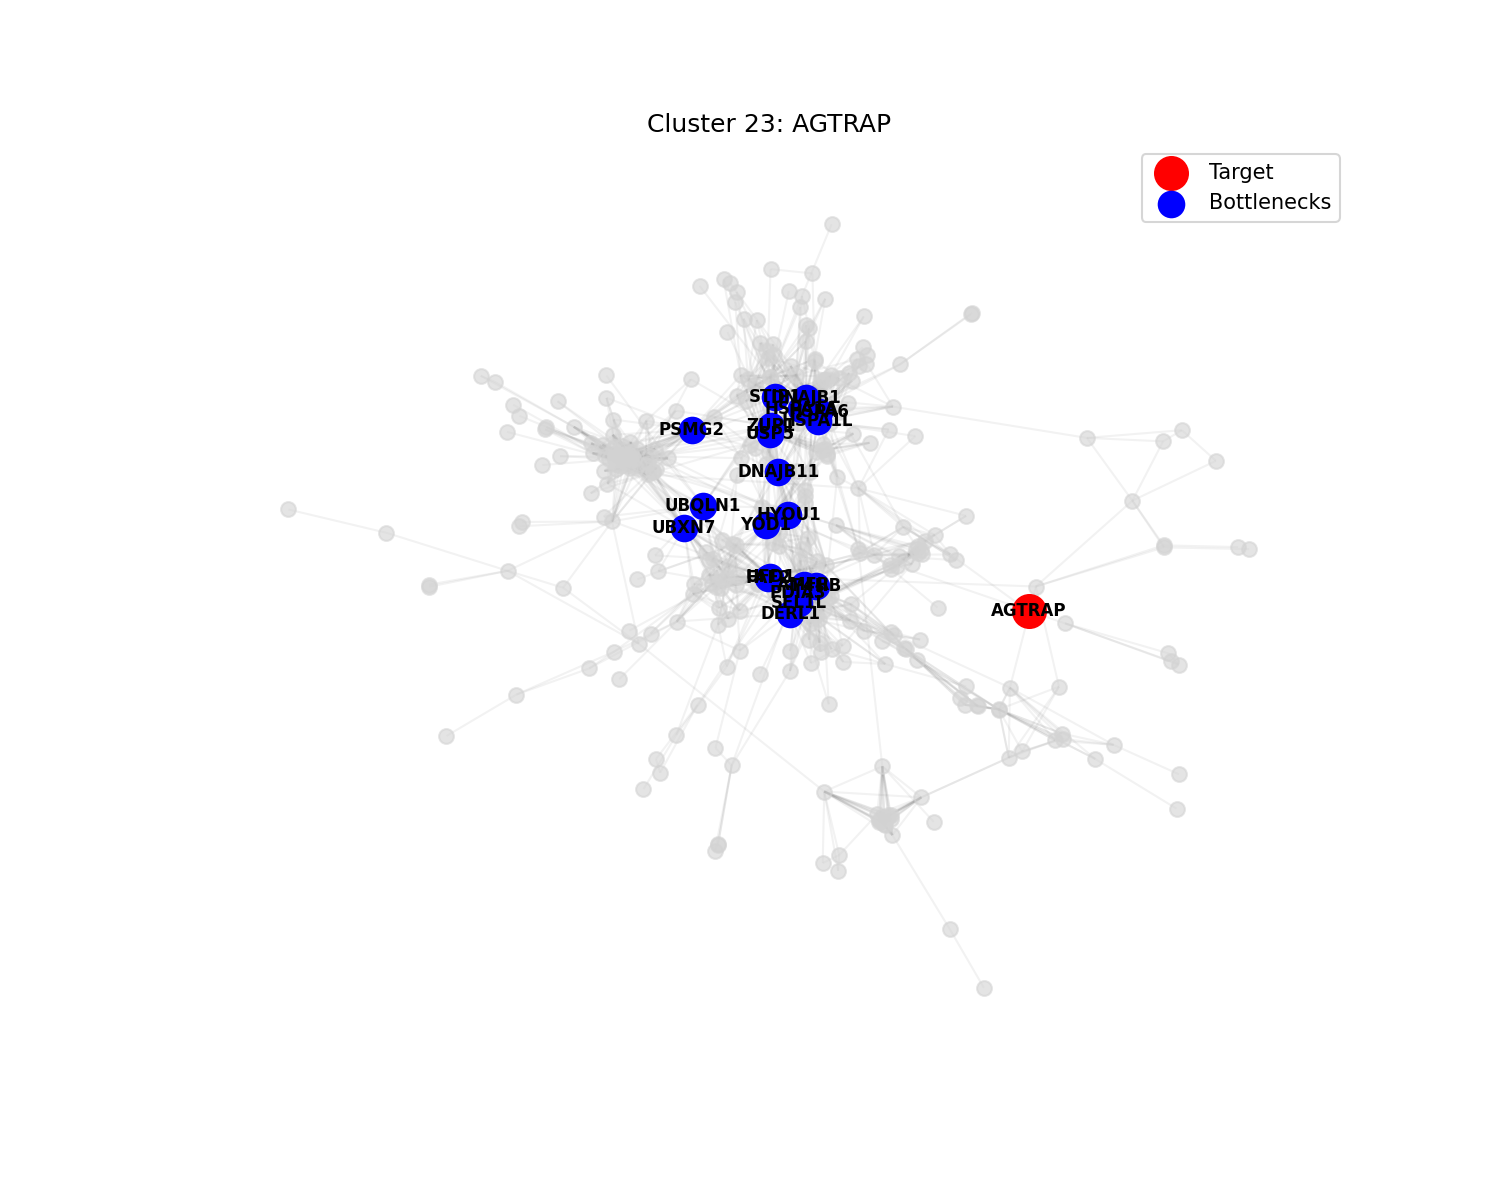

In [7]:
import sys
# Ensure Python can find your module folder
sys.path.append('./features/prot_clust_modules')

# Import the specific function
from bottleneck_analysis import btl_anal

# Import display tools
from IPython.display import display, IFrame, Image

# --- USER INPUT ---
TARGET = "AGTRAP" 
PICKLE_FILE = "data/output/louvain_clust_julle.pkl"
OUTPUT_DIR = "data/output"
# ------------------

# Call the function
result = btl_anal(TARGET, PICKLE_FILE, OUTPUT_DIR)

# Check results
if result["error"]:
    print(f"❌ {result['error']}")
else:
    print(f"\n✅ Results for Cluster {result['cluster_id']}:")
    
    # 1. Show Top 10 Dataframe
    display(result["dataframe"].head(10))
    
    # 2. Show Static Image
    print("\n--- Static Visualization ---")
    display(Image(filename=result["png_path"]))
    
    # 3. Show Interactive HTML
    #if result["html_path"]:
        #print("\n--- Interactive Visualization (Scroll/Zoom) ---")
        #display(IFrame(src=result["html_path"], width='100%', height='800px'))

B. Markov Clustering (MCL)

Flow simulation based clustering.

Note:

Instead of running the MCL on your computer, just grap the mcl_data.pkl and put it in the "data/output" directory, file here: https://drive.google.com/drive/folders/1lYrvIDpD_2BXirGHBIgoYeByp1yPRsZ4?usp=sharing

In [5]:
# Uncomment to run High Performance MCL
run_script("features/05_markov_clust_highperformance_object_out.py")


--- 🚀 Starting 05_markov_clust_highperformance_object_out.py...
--- ✅ 05_markov_clust_highperformance_object_out.py finished successfully.


In [8]:
import sys
import pandas as pd

# Ensure python finds your modules
sys.path.append('features/prot_clust_modules')

# Import the new module
from cluster_overview import (
    get_clustering_summary, 
    generate_cluster_stats_table, 
    get_proteins_in_cluster
)

# Config
PICKLE_FILE = "data/output/mcl_data.pkl"
OUTPUT_DIR = "data/output"


Overview of Markov Clustering

In [9]:
# Get high-level facts about the network
df_summary = get_clustering_summary(PICKLE_FILE)


[OVERVIEW] Generating global network summary...

--- Network Summary ---


Total Clusters,Avg Cluster Size,Median Cluster Size,Largest Cluster,Smallest Cluster,Modularity Score
1564,8.420000,4.000000,171,1,0.557600


In [10]:
# Generate table for all clusters
df_all_clusters = generate_cluster_stats_table(
    PICKLE_FILE, 
    output_filename="all_cluster_metrics.csv", 
    output_dir=OUTPUT_DIR
)


[OVERVIEW] Calculating statistics for all clusters...
   ✅ Stats saved to: data/output/all_cluster_metrics.csv

--- Top 20 Largest Clusters ---


,Cluster ID,Size (Nodes),Edges,Density,Avg Clustering
0,0,171,3462,0.2382,0.6766
1,1,165,2745,0.2029,0.5306
2,2,135,1759,0.1945,0.5146
3,3,127,3533,0.4416,0.7249
4,4,118,2299,0.3330,0.7717
5,5,117,713,0.1051,0.4773
6,6,112,2708,0.4356,0.6276
7,7,92,966,0.2308,0.7510
8,8,83,2029,0.5962,0.7694
9,9,81,825,0.2546,0.4451


In [11]:
# Select a cluster ID you are interested in (e.g., based on the table above)
INTERESTING_CLUSTER_ID = 23

# Extract list
protein_list = get_proteins_in_cluster(
    PICKLE_FILE, 
    cluster_id=INTERESTING_CLUSTER_ID, 
    output_filename=f"proteins_in_cluster_{INTERESTING_CLUSTER_ID}.txt",
    output_dir=OUTPUT_DIR
)


[OVERVIEW] Fetching proteins for Cluster ID 23...
   ✅ Saved list to: data/output/proteins_in_cluster_23.txt

--- Proteins in Cluster 23 (Showing top 50 of 55) ---
ACKR2, ACKR3, ACKR4, CCL1, CCL11, CCL13, CCL14, CCL15, CCL16, CCL17, CCL18, CCL19, CCL20, CCL21, CCL22, CCL23, CCL24, CCL25, CCL26, CCL27, CCL28, CCL3L1, CCL4L2, CCL7, CCL8, CCR1, CCR10, CCR3, CCR4, CCR6, CCR8, CCR9, CCRL2, CX3CL1, CX3CR1, CXCL11, CXCL13, CXCL14, CXCL16, CXCL17, CXCL2, CXCL3, CXCL5, CXCL6, CXCR1, CXCR2, CXCR3, CXCR5, CXCR6, PF4
... and 5 more.


Running Target bottlenecks


--- 🔍 Analyzing Target: CCL1 ---
[INFO] Found in Cluster #23 (Size: 55 nodes)
[INFO] Calculating network metrics (Degree, Betweenness, Clustering)...
   > Metrics computed in 0.57s
[INFO] Generating static PNG...
[INFO] Generating interactive HTML...
[SUCCESS] Analysis finished for CCL1.

✅ Results for Cluster 23:


,Protein,Total_Score,BC,Degree,Clustering
0,CCR3,7,0.037037,48,0.567663
1,CCL20,18,0.023760,45,0.577711
2,CXCR5,22,0.020964,45,0.581312
3,CCR10,24,0.036688,41,0.570600
4,CCL21,26,0.008036,46,0.570143
5,CCR9,28,0.017121,41,0.560260
6,CXCR2,32,0.013277,44,0.596858
7,CCL27,33,0.018169,41,0.574277
8,CXCR3,35,0.010482,45,0.596579
9,XCR1,35,0.047869,31,0.436241



--- Static Visualization ---


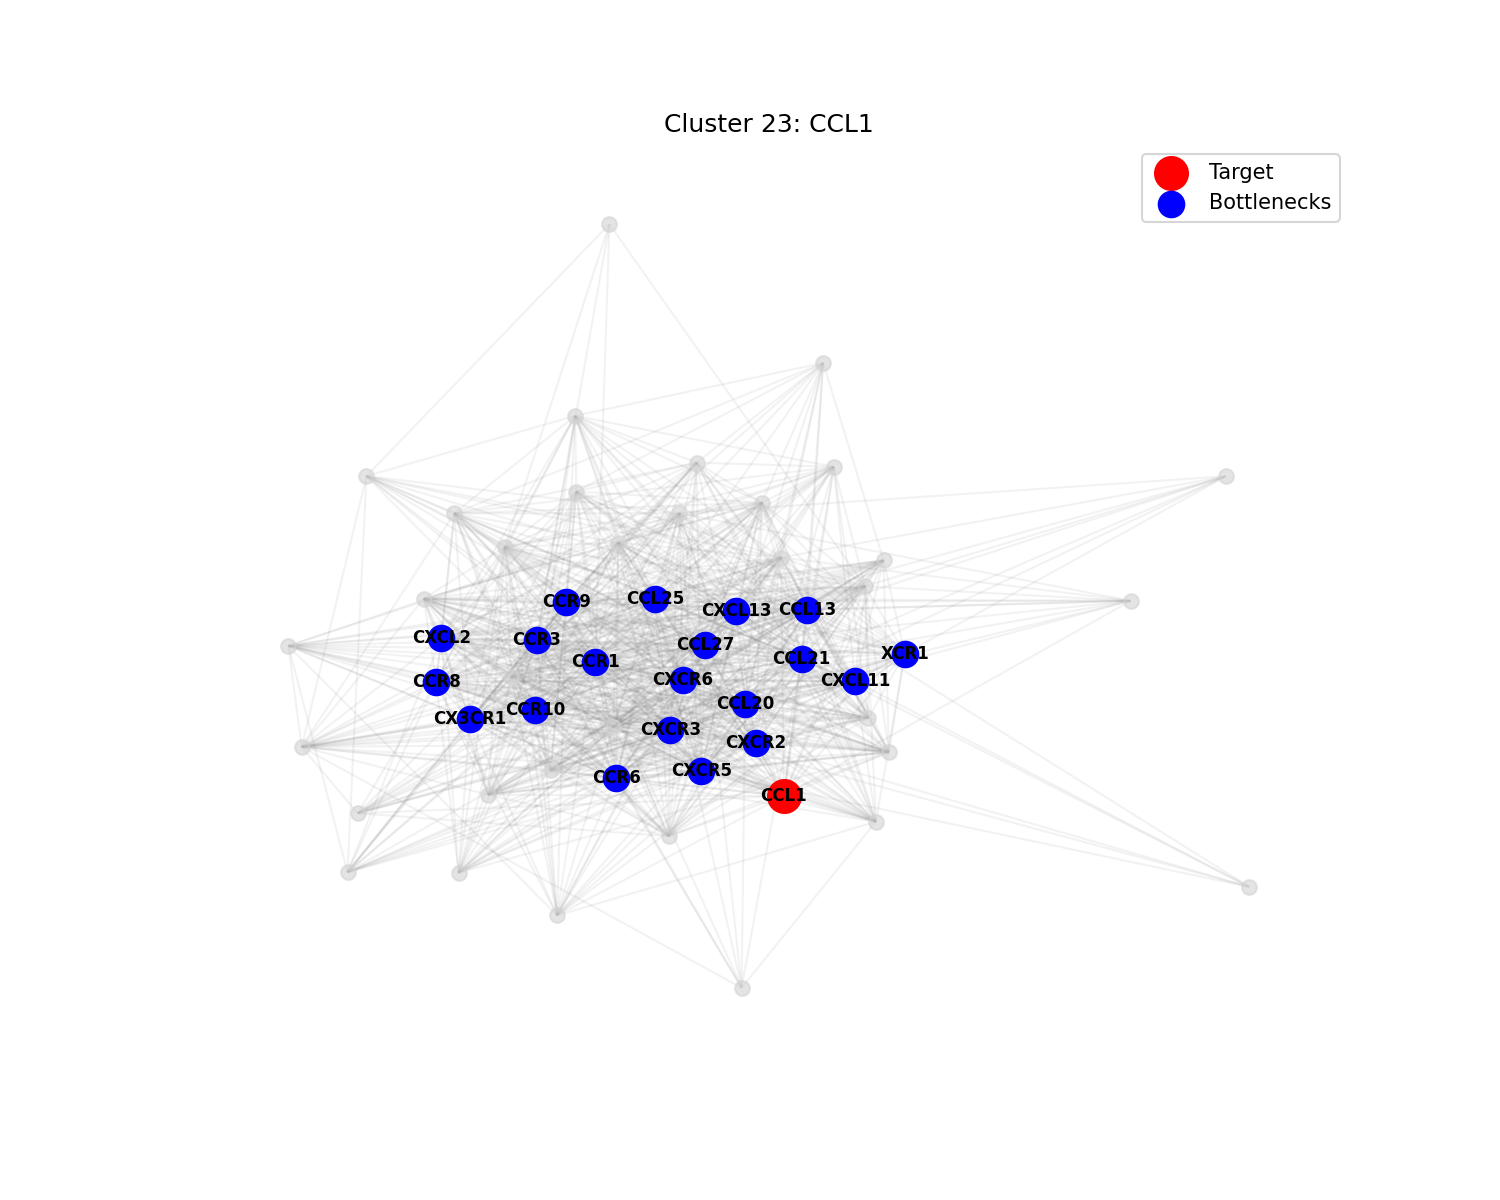

In [12]:
import sys
# Ensure Python can find your module folder
sys.path.append('./features/prot_clust_modules')

# Import the specific function
from bottleneck_analysis import btl_anal

# Import display tools
from IPython.display import display, IFrame, Image

# --- USER INPUT ---
target_protein = "CCL1" 
pickle_file = PICKLE_FILE
output_dir = OUTPUT_DIR
# ------------------

# Call the function
result = btl_anal(target_protein, pickle_file, output_dir)

# Check results
if result["error"]:
    print(f"❌ {result['error']}")
else:
    print(f"\n✅ Results for Cluster {result['cluster_id']}:")
    
    # 1. Show Top 10 Dataframe
    display(result["dataframe"].head(10))
    
    # 2. Show Static Image
    print("\n--- Static Visualization ---")
    display(Image(filename=result["png_path"]))
    
    # 3. Show Interactive HTML
    #if result["html_path"]:
        #print("\n--- Interactive Visualization (Scroll/Zoom) ---")
        #display(IFrame(src=result["html_path"], width='100%', height='800px'))

In [21]:
TARGET_PROTEIN = "CCL1"

import sys
import os
from IPython.display import display, HTML

# 1. Add your modules folder to the path so Python can find it
# (Only needs to be done once per notebook session)
if 'features/prot_clust_modules' not in sys.path:
    sys.path.append('./features/prot_clust_modules')

# Force reload to get latest code
import importlib
if 'enrichment_analysis_2' in sys.modules:
    importlib.reload(sys.modules['enrichment_analysis_2'])

#enrichment analysis
# 2. Import the function
from enrichment_analysis_2 import run_enrichment_analysis

# --- USER CONFIGURATION ---
target_protein = TARGET_PROTEIN             # The protein you are investigating
pickle_file = PICKLE_FILE # Or "louvain_data.pkl" depending on which method you want to test
output_dir = OUTPUT_DIR             # Where to save the CSV results
# --------------------------

print(f"🔬 Starting Enrichment Analysis for target: {TARGET_PROTEIN}...")

# 3. Run the analysis
# This function will:
#   - Load the graph data
#   - Find the cluster containing SNCAIP
#   - Run ORA (Over-Representation Analysis) against Hallmark gene sets
#   - Save results to CSV
#   - Display top pathways automatically
results_df = run_enrichment_analysis(target_protein, pickle_file, output_dir,clust_algo_used="MCL")

🔬 Starting Enrichment Analysis for target: CCL1...

--- 🧬 Enrichment Analysis (g:Profiler): CCL1 ---
[INFO] Target found in Cluster #23
[INFO] Analyzing 55 genes against GO:BP and Reactome...
[INFO] Background size: 13163 genes
[INFO] Initializing g:Profiler...
[INFO] Querying g:Profiler API...
   ✅ Full results saved to: data/output/enrichment_cluster_23_MCL.csv

--- Top Enriched Pathways (FDR < 0.05) ---
   ✅ Full results saved to: data/output/enrichment_cluster_23_MCL.csv

--- Top Enriched Pathways (FDR < 0.05) ---


,Source,Term,Overlap,Adjusted P-value,Genes
0,GO:BP,chemokine-mediated signaling pathway,50/70,3.66e-115,"['CX3CR1', 'PF4', 'CXCR1', 'XCL1', 'CCL7', 'CXCR2', 'XCR1', 'CXCL3', 'CCL17', 'XCL2', 'CCL11', 'CCL22', 'CCL25', 'CCL18', 'CX3CL1', 'CXCL13', 'CCL26', 'CXCR6', 'CCRL2', 'CXCL5', 'CXCL2', 'CCR10', 'PPBP', 'CCL13', 'CCL16', 'CCR4', 'ACKR4', 'CCR3', 'CCL14', 'CXCL6', 'CCR9', 'CCL20', 'CCR8', 'CCL21', 'CXCR5', 'CCL15', 'CXCR3', 'CCL1', 'CCL8', 'CCR1', 'CXCL11', 'PF4V1', 'CCL24', 'ACKR3', 'CCL19', 'CCL4L2', 'CCR6', 'CCL3L1', 'ACKR2', 'CCL23']"
1,REAC,Chemokine receptors bind chemokines,44/44,1.07e-114,"['CX3CR1', 'PF4', 'CXCR1', 'XCL1', 'CCL7', 'CXCR2', 'XCR1', 'CXCL3', 'CCL17', 'CXCL16', 'XCL2', 'CCL11', 'CCL22', 'CCL25', 'CX3CL1', 'CXCL13', 'CXCR6', 'CCRL2', 'CXCL5', 'CXCL2', 'CCR10', 'PPBP', 'CCL13', 'CCL16', 'CCR4', 'ACKR4', 'CCR3', 'CXCL6', 'CCR9', 'CCL28', 'CCL20', 'CCR8', 'CCL21', 'CXCR5', 'CXCR3', 'CCL1', 'CCR1', 'CXCL11', 'CCL27', 'ACKR3', 'CCL19', 'CCR6', 'CCL3L1', 'ACKR2']"
2,GO:BP,response to chemokine,50/78,9.18e-112,"['CX3CR1', 'PF4', 'CXCR1', 'XCL1', 'CCL7', 'CXCR2', 'XCR1', 'CXCL3', 'CCL17', 'XCL2', 'CCL11', 'CCL22', 'CCL25', 'CCL18', 'CX3CL1', 'CXCL13', 'CCL26', 'CXCR6', 'CCRL2', 'CXCL5', 'CXCL2', 'CCR10', 'PPBP', 'CCL13', 'CCL16', 'CCR4', 'ACKR4', 'CCR3', 'CCL14', 'CXCL6', 'CCR9', 'CCL20', 'CCR8', 'CCL21', 'CXCR5', 'CCL15', 'CXCR3', 'CCL1', 'CCL8', 'CCR1', 'CXCL11', 'PF4V1', 'CCL24', 'ACKR3', 'CCL19', 'CCL4L2', 'CCR6', 'CCL3L1', 'ACKR2', 'CCL23']"
3,GO:BP,cellular response to chemokine,50/78,9.18e-112,"['CX3CR1', 'PF4', 'CXCR1', 'XCL1', 'CCL7', 'CXCR2', 'XCR1', 'CXCL3', 'CCL17', 'XCL2', 'CCL11', 'CCL22', 'CCL25', 'CCL18', 'CX3CL1', 'CXCL13', 'CCL26', 'CXCR6', 'CCRL2', 'CXCL5', 'CXCL2', 'CCR10', 'PPBP', 'CCL13', 'CCL16', 'CCR4', 'ACKR4', 'CCR3', 'CCL14', 'CXCL6', 'CCR9', 'CCL20', 'CCR8', 'CCL21', 'CXCR5', 'CCL15', 'CXCR3', 'CCL1', 'CCL8', 'CCR1', 'CXCL11', 'PF4V1', 'CCL24', 'ACKR3', 'CCL19', 'CCL4L2', 'CCR6', 'CCL3L1', 'ACKR2', 'CCL23']"
4,GO:BP,cell chemotaxis,55/251,2.32e-95,"['CX3CR1', 'PF4', 'CXCR1', 'XCL1', 'CXCL14', 'CCL7', 'CXCR2', 'XCR1', 'CXCL3', 'CCL17', 'CXCL16', 'XCL2', 'CCL11', 'CCL22', 'CCL25', 'CCL18', 'CX3CL1', 'CXCL13', 'CCL26', 'CXCR6', 'CCRL2', 'CXCL5', 'CXCL2', 'CCR10', 'PPBP', 'CCL13', 'CCL16', 'CCR4', 'ACKR4', 'CXCL17', 'CCR3', 'CCL14', 'CXCL6', 'CCR9', 'CCL28', 'CCL20', 'CCR8', 'CCL21', 'CXCR5', 'CCL15', 'CXCR3', 'CCL1', 'CCL8', 'CCR1', 'CXCL11', 'PF4V1', 'CCL27', 'CCL24', 'ACKR3', 'CCL19', 'CCL4L2', 'CCR6', 'CCL3L1', 'ACKR2', 'CCL23']"
5,GO:BP,chemotaxis,55/375,6.72e-85,"['CX3CR1', 'PF4', 'CXCR1', 'XCL1', 'CXCL14', 'CCL7', 'CXCR2', 'XCR1', 'CXCL3', 'CCL17', 'CXCL16', 'XCL2', 'CCL11', 'CCL22', 'CCL25', 'CCL18', 'CX3CL1', 'CXCL13', 'CCL26', 'CXCR6', 'CCRL2', 'CXCL5', 'CXCL2', 'CCR10', 'PPBP', 'CCL13', 'CCL16', 'CCR4', 'ACKR4', 'CXCL17', 'CCR3', 'CCL14', 'CXCL6', 'CCR9', 'CCL28', 'CCL20', 'CCR8', 'CCL21', 'CXCR5', 'CCL15', 'CXCR3', 'CCL1', 'CCL8', 'CCR1', 'CXCL11', 'PF4V1', 'CCL27', 'CCL24', 'ACKR3', 'CCL19', 'CCL4L2', 'CCR6', 'CCL3L1', 'ACKR2', 'CCL23']"
6,GO:BP,taxis,55/377,7.68e-85,"['CX3CR1', 'PF4', 'CXCR1', 'XCL1', 'CXCL14', 'CCL7', 'CXCR2', 'XCR1', 'CXCL3', 'CCL17', 'CXCL16', 'XCL2', 'CCL11', 'CCL22', 'CCL25', 'CCL18', 'CX3CL1', 'CXCL13', 'CCL26', 'CXCR6', 'CCRL2', 'CXCL5', 'CXCL2', 'CCR10', 'PPBP', 'CCL13', 'CCL16', 'CCR4', 'ACKR4', 'CXCL17', 'CCR3', 'CCL14', 'CXCL6', 'CCR9', 'CCL28', 'CCL20', 'CCR8', 'CCL21', 'CXCR5', 'CCL15', 'CXCR3', 'CCL1', 'CCL8', 'CCR1', 'CXCL11', 'PF4V1', 'CCL27', 'CCL24', 'ACKR3', 'CCL19', 'CCL4L2', 'CCR6', 'CCL3L1', 'ACKR2', 'CCL23']"
7,REAC,Peptide ligand-binding receptors,44/171,7.44e-74,"['CX3CR1', 'PF4', 'CXCR1', 'XCL1', 'CCL7', 'CXCR2', 'XCR1', 'CXCL3', 'CCL17', 'CXCL16', 'XCL2', 'CCL11', 'CCL22', 'CCL25', 'CX3CL1', 'CXCL13', 'CXCR6', 'CCRL2', 'CXCL5', 'CXCL2', 'CCR10', 'PPBP', 'CCL13', 'CCL16', 'CCR4', 'ACKR4', 'CCR3', 'CXCL6', 'CCR9', 'CCL28', 'CCL20', 'CCR8', 'CCL21', 'CXCR5', 'CXCR3', 'CCL1', 'CCR1', 'CXCL11', 'CCL27', 'ACKR3', 'CCL19', 'CCR6', 'CCL

In [ ]:
print("\n✨ All pipeline tasks complete! ✨")